Step 16: 2D Diffusion Equation using Numpy and JAX
----
***

In this step, we will revise the code from Step 9, which addresses solving the 2D Diffusion Equation, adapting it to utilize JAX. Our focus will be on comparing the computational performance of Numpy and JAX in terms of execution time.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt, cm

#variables declarations

nx = 1001
ny = 1001
nt = 5000
nu = 0.05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = 0.2
dt = sigma * dx * dy / nu


In [ ]:
def diffusion_numpy(u,nt,dx,dy,nu,dt):

    # loop across number of time steps
    for n in range(nt):
        un = u.copy()
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] +
                        nu * dt / dx**2 *
                        (un[2:,1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2,1:-1]) +
                        nu * dt / dy**2 *
                        (un[1:-1,2:] - 2 * un[1:-1, 1:-1] + un[1:-1,0:-2]))
        u[0,:] = 1
        u[-1,:] = 1
        u[:,0] = 1
        u[:,-1] = 1

    return u

In [ ]:
# A = np.zeros((5,5))
# def A_change(A):
#   A[0,0] = 1
#   return A
# print(A)
# B = A_change(A)
# print(A)  ## A will be changed
# print(B)

In [ ]:
# A = jnp.zeros((5,5))
# def A_change(A):
#   A.at[0,0].set(1)
# print(A)
# A_change(A)
# print(A)  ## A will NOT be changed!

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from functools import partial

In [ ]:
@partial(jit, static_argnums=(1,2,3,4,5))
def stepper(u,nt,dx,dy,nu,dt):
  u = u.at[1:-1, 1:-1].set((u[1:-1, 1:-1] +
                        nu * dt / dx**2 *
                        (u[2:,1:-1] - 2 * u[1:-1, 1:-1] + u[0:-2,1:-1]) +
                        nu * dt / dy**2 *
                        (u[1:-1,2:] - 2 * u[1:-1, 1:-1] + u[1:-1,0:-2])))
  # Bounday conditions
  u = u.at[0,:].set(1)
  u = u.at[-1,:].set(1)
  u = u.at[:,0].set(1)
  u = u.at[:,-1].set(1)
  return u

The line of code you've shared, @partial(jit, static_argnums=(1,2,3,4,5)), is a decorator in Python, specifically designed for use with JAX, a numerical computing library. Let me break down what this line means:

**'@partial'**: This is a function from the functools module in Python, used here to partially apply arguments to another function. In this context, it's modifying the behavior of the jit decorator from JAX.

**'jit'**: This stands for "Just-In-Time" compilation, a feature of JAX that compiles Python functions to optimized machine code for faster execution. jit is particularly effective for operations that can be parallelized, like those on arrays.

**'static_argnums'**: This parameter specifies which arguments of the decorated function are static (i.e., not changing between function calls). This is important because jit needs to know which arguments will remain constant in order to effectively compile the function. In your code, arguments at positions 1, 2, 3, 4, and 5 are marked as static.

In [ ]:
def diffusion_jax(u,nt,dx,dy,nu,dt):

  for n in range(nt):
    u = stepper(u,nt,dx,dy,nu,dt)

  return u

### Run the diffusion_numpy

CPU times: user 58.8 s, sys: 16.7 s, total: 1min 15s
Wall time: 1min 18s


Text(0.5, 0.92, 'u_numpy')

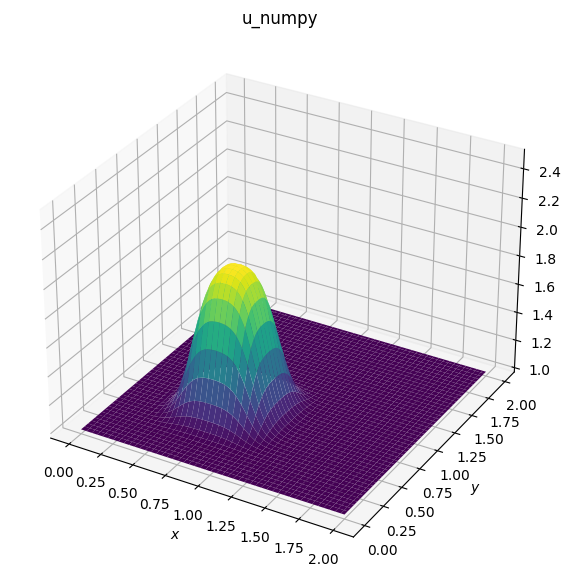

In [ ]:
x = np.linspace(0,2,nx)
y = np.linspace(0,2,nx)
X, Y = np.meshgrid(x,y)
## inital conditions
u_numpy = np.ones((nx,ny))

# set hat function I.C.: u(0.5<=x<=1 && 0.5<=y<=1) = 2
u_numpy[int(0.5/dx):int(1/dx+1),int(0.5/dy):int(1/dy+1)] = 2

#%timeit diffusion_numpy(u_numpy,nt,dx,dy,nu,dt)
%time u_numpy = diffusion_numpy(u_numpy,nt,dx,dy,nu,dt)

# Plotting u_numpy
fig1 = plt.figure(figsize=(11, 7), dpi=100)
ax1 = fig1.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(X, Y, u_numpy, cmap=cm.viridis)
ax1.set_zlim(1, 2.5)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$');
ax1.set_title('u_numpy')


### Run the diffusion_jax

CPU times: user 822 ms, sys: 258 ms, total: 1.08 s
Wall time: 1.03 s


Text(0.5, 0.92, 'u_jax')

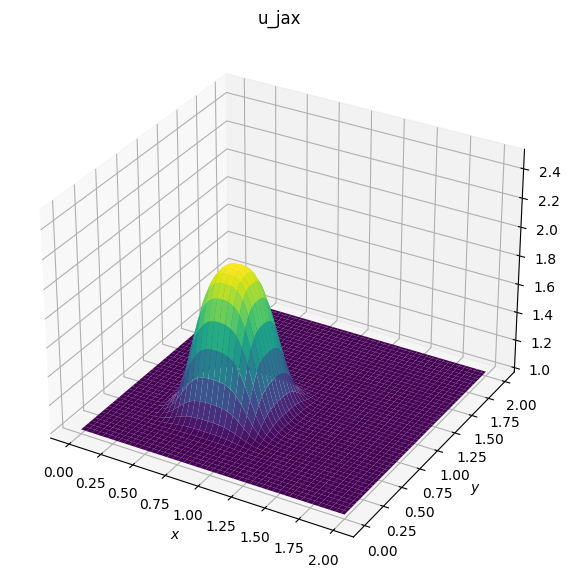

In [ ]:
u_jax = jnp.ones((nx,ny)) # create 2d array of 1's
## initial conditions

# set hat function I.C.: u(0.5<=x<=1 && 0.5<=y<=1) = 2
u_jax = u_jax.at[int(0.5/dx):int(1/dx + 1), int(0.5/dy):int(1/dy + 1)].set(2)
#The .at interface allows for a more familiar and compact notation,
#while preserving the immutable array semantics of JAX.


%time u_jax = diffusion_jax(u_jax,nt,dx,dy,nu,dt)

# Plotting u_jax
fig2 = plt.figure(figsize=(11, 7), dpi=100)
ax2 = fig2.add_subplot(111, projection='3d')

surf2 = ax2.plot_surface(X, Y, u_jax, cmap=cm.viridis)
ax2.set_zlim(1, 2.5)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$');
ax2.set_title('u_jax')

The comparison reveals a significant performance enhancement: the JAX version, when run on GPUs, is approximately **80 times faster** than the Numpy version. This improvement dramatically reduces the execution time from 80 seconds to just 1 second!